### Import Libraries

In [35]:
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import requests
import json
import re
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

### Scrape imdb website to find the top 250 movies

In [36]:
movie_list = []

def scrape_imdb_top_movies():
    """Scrape IMDB website, so we have a list of movies to analyze"""

    url = 'https://www.imdb.com/chart/top/?ref_=nv_mv_250'

    response = requests.get(url, headers={"User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:130.0) Gecko/20100101 Firefox/130.0"})
    
    soup = BeautifulSoup(response.content, 'html.parser')
    
    content_script_tag = soup.find('script', type='application/ld+json')
    
    # Load JSON data
    json_data = json.loads(content_script_tag.string)
        
    movies = json_data['itemListElement']
    for movie in movies:
        name = movie['item']['name']
        genre = movie['item'].get('genre', 'N/A')  # Use .get() in case the field is missing
        description = movie['item'].get('description', 'N/A')
        duration = movie['item'].get('duration', 'N/A')
        content_rating = movie['item'].get('contentRating', 'N/A')
        rating = movie['item']['aggregateRating'].get('ratingValue', 'N/A')
        
        # Append to list
        movie_list.append([name, genre, description, duration, content_rating, rating])
    

    # Convert list to a pandas DataFrame
    return pd.DataFrame(movie_list, columns=['Name', 'Genre', 'Description', 'Duration', 'ContentRating', 'Rating'])


movie_df = scrape_imdb_top_movies()

### (Optional) Adding some "dirty" records, so we we can see cleaning in action

In [37]:
# Add 2 dummy records
new_row = pd.DataFrame([
    ['dummy', '', 'dummy description', 123, '', ''],
    ['Viral video', 'Youtube Shorts', 'This is a youtube viral video', 'PT1M', '', '']],
                       columns=['Name', 'Genre', 'Description', 'Duration', 'ContentRating', 'Rating'])

movie_df = pd.concat([movie_df, new_row], ignore_index=True)

# Remove a movie name, so it finds null records
movie_df.loc[3, ['Name']] = ""

### Generate the CSV based on the scrapped results

In [38]:
filename = 'movies_scraped.csv'

outdir = '../data'
if not os.path.exists(outdir):
    os.mkdir(outdir)

fullname = os.path.join(outdir, filename)    
movie_df.to_csv(fullname, sep='|')

### Load Data

In [39]:
df = pd.read_csv('../data/movies_scraped.csv', sep='|')

### Data cleaning (invalid records)

In [40]:
# Pattern to match valid duration formats (PT2H22M, PT2H, PT22M)
valid_duration_pattern = r'^PT(\d+H)?(\d+M)?$'

# Filter out rows with invalid 'Duration' using regex
df = df[df['Duration'].str.match(valid_duration_pattern, na=False)]

df[['Rating']] = df[['Rating']].fillna(value=0)
df[['Name', 'Genre', 'Description', 'Duration', 'ContentRating']] = df[['Name', 'Genre', 'Description', 'Duration', 'ContentRating']].fillna(value="Unknown")

### Data Transformation

In [41]:
# Convert 'Duration' to total minutes
def convert_duration(duration_str):
    hours = 0
    minutes = 0
    hour_match = re.search(r'(\d+)H', duration_str)
    minute_match = re.search(r'(\d+)M', duration_str)
    if hour_match:
        hours = int(hour_match.group(1))
    if minute_match:
        minutes = int(minute_match.group(1))
    return hours * 60 + minutes

# Apply the conversion
df['Duration_in_minutes'] = df['Duration'].apply(convert_duration)

# Replace the HTML entity for apostrophe (&apos;) with the actual apostrophe (')
df = df.replace("&apos;", "'", regex=True)

### Data cleaning (remove outliers)

In [42]:
# Calculate the mean of 'Duration_in_minutes'
mean_duration = df['Duration_in_minutes'].mean()

# Define a percentage tolerance (e.g., 90%)
percentage_tolerance = 0.9

# Calculate dynamic minimum and maximum duration values
min_duration = mean_duration * (1 - percentage_tolerance)
max_duration = mean_duration * (1 + percentage_tolerance)

print(f"Mean Duration: {mean_duration:.2f} minutes")
print(f"Valid Range: {min_duration:.2f} - {max_duration:.2f} minutes")

# Filter the DataFrame to identify outliers based on the dynamic range
df_valids = df[(df['Duration_in_minutes'] >= min_duration) & (df['Duration_in_minutes'] <= max_duration)]

# Perform a left join, so we can identify the outliers based on the valid ones
df_merged = pd.merge(df, df_valids, on=['Name', 'Genre', 'Description'], how='left', suffixes=('', '_valid'))

# Identify the outliers, so they can be further analyzed. Maybe there are some false positives
df_outliers = df_merged[df_merged['Duration_in_minutes_valid'].isnull()]

df = df_valids

Mean Duration: 129.68 minutes
Valid Range: 12.97 - 246.39 minutes


### Checking the outliers, as they might be false positives

In [43]:
df_outliers.head()

,Unnamed: 0,Name,Genre,Description,Duration,ContentRating,Rating,Duration_in_minutes,Unnamed: 0_valid,Duration_valid,ContentRating_valid,Rating_valid,Duration_in_minutes_valid
250,251,Viral video,Youtube Shorts,This is a youtube viral video,PT1M,Unknown,0.0,1,NaN,NaN,NaN,NaN,NaN


### Feature Engineering

In [44]:
# Define a mapping to classify each rating into a category
def classify_rating(rating):
    family_friendly = ['G', 'U', 'Approved', 'Passed']
    family_with_supervision = ['PG', 'PG-13', '12A', 'TV-14']
    adult_only = ['R', 'NC-17', 'Not Rated', 'Unknown', '15', '18', '16']

    if rating in family_friendly:
        return 'Family-Friendly'
    elif rating in family_with_supervision:
        return 'Family-Friendly with Supervision'
    elif rating in adult_only:
        return 'Adult Only'
    else:
        return 'Unclassified'

# Apply the classification to create the 3 separate boolean columns
df['Family_Friendly'] = df['ContentRating'].apply(lambda x: classify_rating(x) == 'Family-Friendly')
df['Family_Friendly_with_Supervision'] = df['ContentRating'].apply(lambda x: classify_rating(x) == 'Family-Friendly with Supervision')
df['Adult_Only'] = df['ContentRating'].apply(lambda x: classify_rating(x) == 'Adult Only')

### One-hot encoding

In [45]:
# Split the 'Genre' column by commas into a list of genres
df['Genre_Split'] = df['Genre'].str.split(', ')

# Explode the DataFrame so that each genre gets its own row
df_exploded = df.explode('Genre_Split')

# Apply one-hot encoding to the exploded 'Genre_Split' column
df_one_hot = pd.get_dummies(df_exploded['Genre_Split'])

# Group by the original movie to aggregate the genres
df_content_matrix = df_one_hot.groupby(df_exploded['Name']).max().reset_index()

df_combined = df_content_matrix.copy()  # Copy the one-hot encoded matrix

# Add other numerical features, like 'Duration_in_minutes'
df_combined = df_combined.merge(df[['Name', 'Duration_in_minutes']], on='Name')

# One-hot encode the 'ContentRating' column
df_content_rating = pd.get_dummies(df[['Name', 'ContentRating']], columns=['ContentRating'])

# Merge the one-hot encoded content rating with the combined matrix based on the 'Name' column
df_combined = df_combined.merge(df_content_rating, on='Name')

### Similarity Matrix

In [46]:
df_numeric = df_combined.drop(columns=['Name'])

# Step 2: Normalize the numerical features (optional, but recommended for balancing feature scales)
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df_numeric), columns=df_numeric.columns)

# Step 3: Calculate cosine similarity based on the structured features
cosine_sim_matrix = cosine_similarity(df_normalized)

# Step 4: Convert the similarity matrix to a DataFrame for better readability
cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=df_combined['Name'], columns=df_combined['Name'])


### Find similar movies (using structured data)

In [47]:
# Movie name that you want to find similar ones
movie_name = 'The Lord of the Rings: The Return of the King'

similar_movies = cosine_sim_df[movie_name]

sorted_similar_movies = similar_movies.sort_values(ascending=False)

# Exclude the movie itself from the list (similarity with itself is always 1)
sorted_similar_movies = sorted_similar_movies[sorted_similar_movies.index != movie_name]

# Display the sorted list of similar movies
sorted_similar_movies.head(10)

Name
The Lord of the Rings: The Two Towers                0.998753
The Lord of the Rings: The Fellowship of the Ring    0.998635
Dune: Part Two                                       0.996777
Top Gun: Maverick                                    0.870508
Indiana Jones and the Last Crusade                   0.869080
Avengers: Endgame                                    0.780359
Interstellar                                         0.776640
The Dark Knight Rises                                0.774888
Gladiator                                            0.771427
The Dark Knight                                      0.770184
Name: The Lord of the Rings: The Return of the King, dtype: float64

### Exploratory Data Analaysis

#### Distribution of Movie Durations

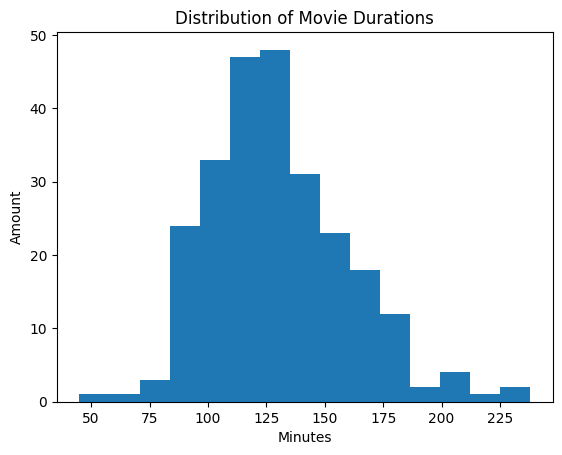

In [48]:
# using square root as this is simple and useful for general purposes
num_bins = int(np.sqrt(len(df['Duration_in_minutes'])))

# plot the histogram with the calculated number of bins
plt.hist(df['Duration_in_minutes'], bins=num_bins)

plt.title('Distribution of Movie Durations')
plt.xlabel('Minutes')
plt.ylabel('Amount')
plt.show()


#### Genre Analysis

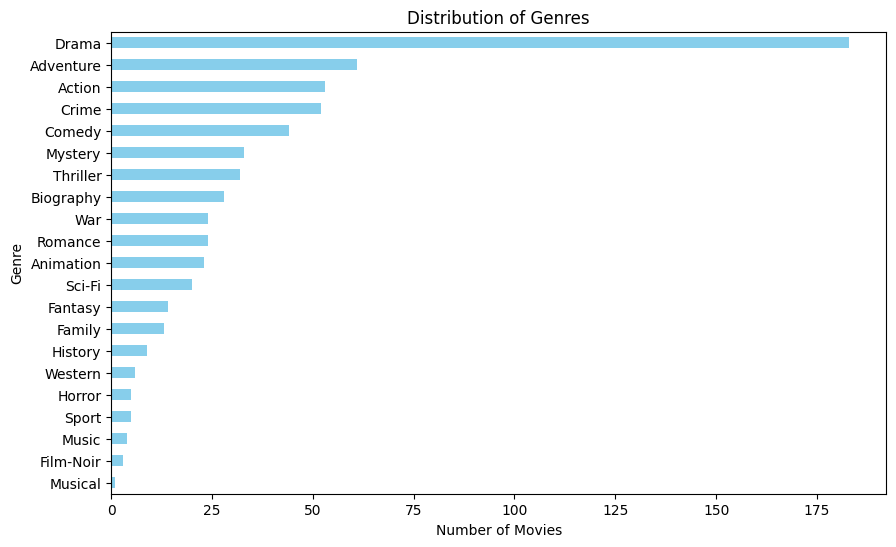

In [49]:
# Get the genre counts and sort them in descending order
genre_counts = df['Genre'].str.split(', ').explode().value_counts().sort_values(ascending=True)

# Plot the horizontal bar chart with sorted values
genre_counts.plot(kind='barh', figsize=(10, 6), color='skyblue')

# Add titles and labels
plt.title('Distribution of Genres')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.show()
